In [31]:
import pandas as pd 
import seaborn as sns

import mlflow
import mlflow.sklearn as mlflow_sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import tree

# Importation des données et choisir les Features

In [32]:
data = pd.read_csv("D:/DossierSara/DEDS/semester 3/python/Projet/voice.csv")
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [33]:
# Obtenir des informations sur le data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [34]:
data.isnull().values.any()

False

# Ajustement des valeurs de label (mâle = 1, femelle = 0 )

Après avoir obtenu des informations sur les données, nous appellerons homme 1 et femme 0 

In [35]:
data.label = [1 if each == "male" else 0 for each in data.label]
data['label'] # maintenant nous avons une Label en tant qu'entier

0       1
1       1
2       1
3       1
4       1
       ..
3163    0
3164    0
3165    0
3166    0
3167    0
Name: label, Length: 3168, dtype: int64

# Normalisation des données

In [36]:
X=data.drop(['label'],axis=1)  # composants de prédiction
y=data['label'] # principaux résultats homme ou femme

In [37]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Opération de fractionnement pour les données d'apprentissage et de test

Les données sont séparées pour les opérations de formation et de test. Nous aurons 20 % de données pour le test et 80 % de données pour le train après l'opération fractionnée.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [39]:
# Formes de données
print("x_train.shape : ", x_train.shape)
print("x_test.shape : ", x_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

x_train.shape :  (2534, 20)
x_test.shape :  (634, 20)
y_train.shape :  (2534,)
y_test.shape :  (634,)


# Mlflow 

In [40]:
mlflow.create_experiment('Voice_Models_Classification') # creation d'un experiment 

MlflowException: Experiment 'Voice_Models_Classification' already exists.

In [41]:
mlflow.set_experiment('Voice_Models_Classification') # 

<Experiment: artifact_location='file:///D:/DossierSara/DEDS/semester%203/python/Projet/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Voice_Models_Classification', tags={}>

In [43]:
def log_run(run_name, model, val_x, val_y):
    
    ## Démarrer avec le nom donné
    mlflow.start_run(run_name=run_name, nested=True)
    
    ## Obtenir une prédiction sur l'ensemble de données de validation
    val_pred = model.predict(val_x)
    
    ## log tous les hyperparamètres
    mlflow.log_params(model.get_params())
        
    ## Calculer les métriques requises
    precision, recall, fscore, support = precision_recall_fscore_support(val_y, val_pred, average='micro')
    
    ## log tous les paramètres requis
    mlflow.log_metrics(
        {'precision': precision, 'recall': recall, 'fscore': fscore}
    )
    
    ## Cela enregistre les modèles basés sur sklearn en les convertissant en pickle
    mlflow_sklearn.log_model(model, run_name)
    
    mlflow.end_run()

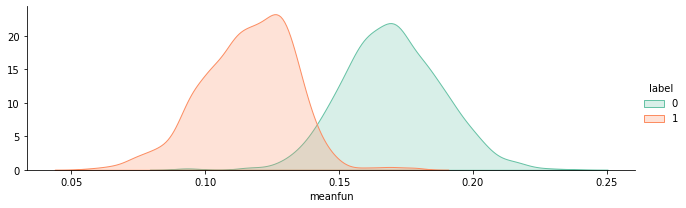

In [44]:
fig_fun = sns.FacetGrid(data, hue="label", aspect=3, palette="Set2") # aspect=3 permet d'allonger le graphique
fig_fun.map(sns.kdeplot, "meanfun", shade=True)
fig_fun.add_legend()
fig_fun.savefig('label_Moyenne_amusante.png')
mlflow.log_artifact('label_Moyenne_amusante.png')

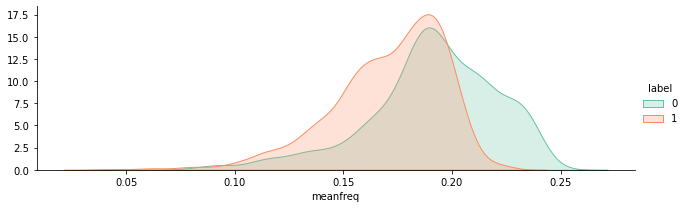

In [45]:
fig_freg = sns.FacetGrid(data, hue="label", aspect=3, palette="Set2") # aspect=3 permet d'allonger le graphique
fig_freg.map(sns.kdeplot, "meanfreq", shade=True)
fig_freg.add_legend()
fig_freg.savefig('label_Moyenne_freq.png')
mlflow.log_artifact('label_Moyenne_freq.png')

# random forest Classifier 

In [46]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

RandomForestClassifier()

In [47]:
log_run('Random_Forest_default_param', rf_model, x_test, y_test)

# Decision Tree Classifier

In [48]:
dtc=tree.DecisionTreeClassifier()
dtc.fit(x_train,y_train)

DecisionTreeClassifier()

In [49]:
log_run('Decision_Tree_model', dtc, x_test, y_test)

# SVM

In [50]:
svm = svm.SVC()
svm.fit(x_train, y_train)

SVC()

In [51]:
log_run('SVM_model', dtc, x_test, y_test)